# **Machine Learning - Forecasting the number of call**



*Import des librairies nécessaires*

In [2]:
import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # For analysing and manipulating data
from datetime import date, timedelta # Date Functions
from pandas.plotting import register_matplotlib_converters # Adds plotting functions for calender dates
import matplotlib.pyplot as plt # For visualization
import matplotlib.dates as mdates # Formatting dates
from sklearn.metrics import mean_absolute_error, mean_squared_error # For measuring model performance / errors
from sklearn.preprocessing import MinMaxScaler #to normalize the price data 
from keras.models import Sequential # Deep learning library, used for neural networks
from keras.layers import LSTM, Dense # Deep learning classes for recurrent and regular densely-connected layers
import yfinance as yf
import Load_data

In [3]:
df_export = Load_data.data_from_csv_file("Data/BTCUSDT_1day_january_2020.csv")
df_export


,timestamp,open,high,low,close,volume
0,2020-01-01,7195.24,7255.00,7175.15,7200.85,16792.388165
1,2020-01-02,7200.77,7212.50,6924.74,6965.71,31951.483932
2,2020-01-03,6965.49,7405.00,6871.04,7344.96,68428.500451
3,2020-01-04,7345.00,7404.00,7272.21,7354.11,29987.974977
4,2020-01-05,7354.19,7495.00,7318.00,7358.75,38331.085604
...,...,...,...,...,...,...
864,2022-05-14,29287.05,30343.27,28630.00,30086.74,51095.878630
865,2022-05-15,30086.74,31460.00,29480.00,31328.89,46275.669120
866,2022-05-16,31328.89,31328.90,29087.04,29874.01,73082.196580
867,2022-05-17,29874.01,30788.37,29450.38,30444.93,56724.133070


In [4]:
test_data = df_export
test_data


,timestamp,open,high,low,close,volume
0,2020-01-01,7195.24,7255.00,7175.15,7200.85,16792.388165
1,2020-01-02,7200.77,7212.50,6924.74,6965.71,31951.483932
2,2020-01-03,6965.49,7405.00,6871.04,7344.96,68428.500451
3,2020-01-04,7345.00,7404.00,7272.21,7354.11,29987.974977
4,2020-01-05,7354.19,7495.00,7318.00,7358.75,38331.085604
...,...,...,...,...,...,...
864,2022-05-14,29287.05,30343.27,28630.00,30086.74,51095.878630
865,2022-05-15,30086.74,31460.00,29480.00,31328.89,46275.669120
866,2022-05-16,31328.89,31328.90,29087.04,29874.01,73082.196580
867,2022-05-17,29874.01,30788.37,29450.38,30444.93,56724.133070


In [5]:
df = df_export
df.tail()

,timestamp,open,high,low,close,volume
864,2022-05-14,29287.05,30343.27,28630.00,30086.74,51095.87863
865,2022-05-15,30086.74,31460.00,29480.00,31328.89,46275.66912
866,2022-05-16,31328.89,31328.90,29087.04,29874.01,73082.19658
867,2022-05-17,29874.01,30788.37,29450.38,30444.93,56724.13307
868,2022-05-18,30444.93,30709.99,28750.00,29163.45,43037.03438


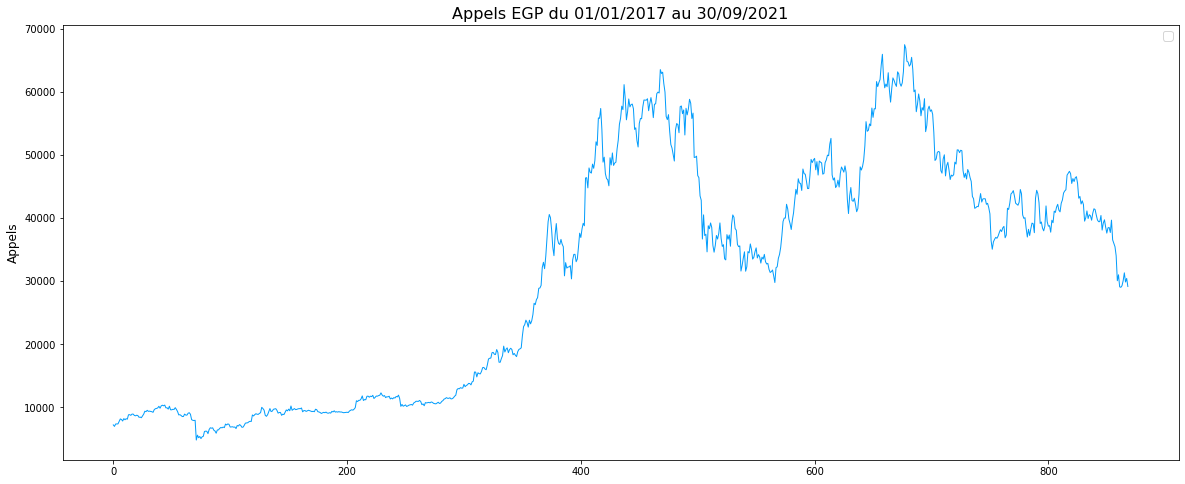

In [6]:
fig, ax1 = plt.subplots(figsize=(20, 8))
x = df.index
y = df["close"]
ax1.legend("Sollicitations", fontsize=12)
plt.title("Appels EGP du 01/01/2017 au 30/09/2021", fontsize=16)
plt.plot(y, color='#039dfc', label="Sollicitations", linewidth=1.0)
plt.ylabel('Appels', fontsize=12)
plt.show()

In [7]:
# Feature Selection - Only Close Data
train_df = df.filter(['close'])
data_unscaled = train_df.values

# Get the number of rows to train the model on 80% of the data 
train_data_length = math.ceil(len(data_unscaled) * 0.9)

# Transform features by scaling each feature to a range between 0 and 1
mmscaler = MinMaxScaler(feature_range=(0, 1))
np_data = mmscaler.fit_transform(data_unscaled)


In [8]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Prediction Index
index_Close = train_df.columns.get_loc("close")
print(index_Close)
# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data.shape[0] * 0.9)

# Create the training and test data
train_data = np_data[0:train_data_len, :]
test_data = np_data[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, train_df):
    x, y = [], []
    data_len = train_df.shape[0]
    for i in range(sequence_length, data_len):
        x.append(train_df[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(train_df[i, index_Close]) #contains the prediction values for validation (3rd column = Close),  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_test[1][sequence_length-1][index_Close])
print(y_test[0])


0
(733, 50, 1) (733,)
(86, 50, 1) (86,)
0.5329595479246748
0.5329595479246748


In [9]:
# Configure the neural network model
model = Sequential()

neurons = sequence_length

# Model with sequence_length Neurons 
# inputshape = sequence_length Timestamps
model.add(LSTM(neurons, return_sequences=True, input_shape=(x_train.shape[1], 1))) 
model.add(LSTM(neurons, return_sequences=False))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))


# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

2022-05-18 19:05:06.743012: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-18 19:05:06.743041: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (doudou): /proc/driver/nvidia/version does not exist
2022-05-18 19:05:06.744246: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
# Training the model
model.fit(x_train, y_train, batch_size=16, epochs=100)


Epoch 1/100
46/46 [==============================] - 9s 46ms/step - loss: 0.0326
Epoch 2/100
46/46 [==============================] - 1s 26ms/step - loss: 0.0033
Epoch 3/100
46/46 [==============================] - 1s 28ms/step - loss: 0.0027
Epoch 4/100
46/46 [==============================] - 1s 25ms/step - loss: 0.0025
Epoch 5/100
46/46 [==============================] - 1s 27ms/step - loss: 0.0022
Epoch 6/100
46/46 [==============================] - 1s 21ms/step - loss: 0.0022
Epoch 7/100
46/46 [==============================] - 1s 22ms/step - loss: 0.0022
Epoch 8/100
46/46 [==============================] - 1s 22ms/step - loss: 0.0020
Epoch 9/100
46/46 [==============================] - 1s 21ms/step - loss: 0.0018
Epoch 10/100
46/46 [==============================] - 1s 22ms/step - loss: 0.0018
Epoch 11/100
46/46 [==============================] - 1s 22ms/step - loss: 0.0017
Epoch 12/100
46/46 [==============================] - 1s 21ms/step - loss: 0.0015
Epoch 13/100
46/46 [=====

In [11]:
  # Get the predicted values
y_pred_scaled = model.predict(x_test)
y_pred = mmscaler.inverse_transform(y_pred_scaled)
y_test_unscaled = mmscaler.inverse_transform(y_test.reshape(-1, 1))

In [12]:

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 1534.62
Mean Absolute Percentage Error (MAPE): 3.99 %
Median Absolute Percentage Error (MDAPE): 3.23 %


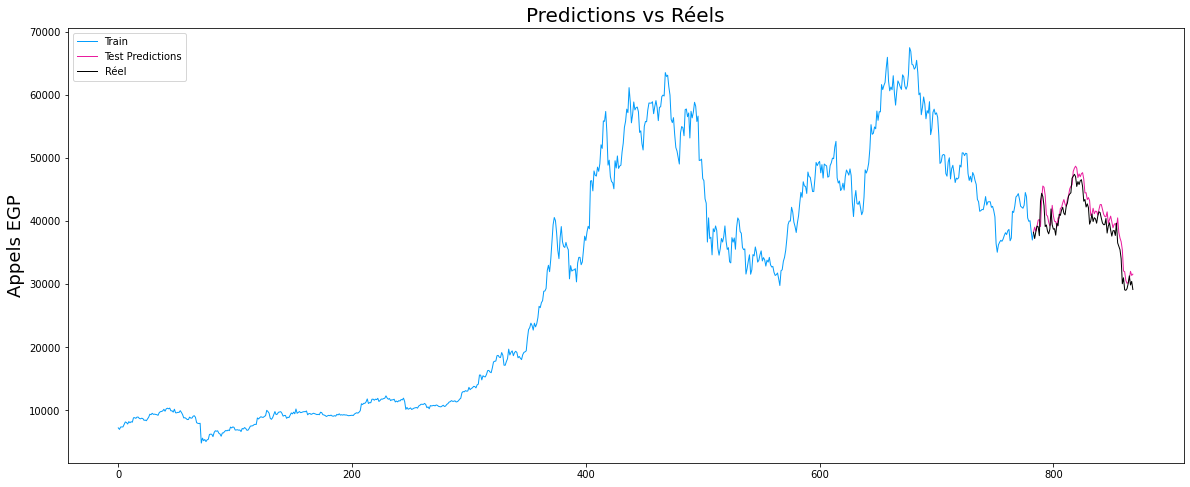

In [13]:

# The date from which on the date is displayed
display_start_date = "2021-01-04" 

# Add the difference between the valid and predicted prices
train = train_df[:train_data_length + 1]
valid = train_df[train_data_length:]
valid.insert(1, "Predictions", y_pred, True)
valid.insert(1, "Difference", valid["Predictions"] - valid["close"], True)


# Zoom in to a closer timeframe
#valid = valid[valid.index > display_start_date]
#train = train[train.index > display_start_date]

# Visualize the data
fig, ax = plt.subplots(figsize=(20, 8), sharex=True)

plt.title("Predictions vs Réels", fontsize=20)
plt.ylabel("Appels EGP", fontsize=18)
plt.plot(train["close"], color="#039dfc", linewidth=1.0)
plt.plot(valid["Predictions"], color="#E91D9E", linewidth=1.0)
plt.plot(valid["close"], color="black", linewidth=1.0)
plt.legend(["Train", "Test Predictions", "Réel"], loc="upper left")
plt.show()

In [14]:
valid.tail(10)

,close,Difference,Predictions
859,30076.31,5384.486875,35460.796875
860,31017.10,1081.110938,32098.210938
861,29103.94,2875.647891,31979.587891
862,29029.75,1568.523438,30598.273438
863,29287.05,854.239063,30141.289062
864,30086.74,149.599844,30236.339844
865,31328.89,-441.720078,30887.169922
866,29874.01,2169.226328,32043.236328
867,30444.93,950.862969,31395.792969
868,29163.45,2432.639844,31596.089844


In [15]:
valid.loc['2021-09-01':].abs().sum()/len(valid.loc['2021-09-01':])

close          39667.556977
Difference      1534.615522
Predictions    40955.566860
dtype: float64

**Predict one day ahead**


In [16]:
# Get fresh data until today
df_new = df.filter(['close'])

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_days_scaled = mmscaler.transform(df_new[-sequence_length:].values)

# Create an empty list and Append past n days
X_test = []
X_test.append(last_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Get the predicted scaled price, undo the scaling and output the predictions
pred_price = model.predict(X_test)
pred_price_unscaled = mmscaler.inverse_transform(pred_price)

# Print last price and predicted price for the next day
price_today = round(df_new.iloc[-1], 2)
predicted_price = round(pred_price_unscaled.ravel()[0], 2)
percent = round(100 - (predicted_price * 100)/price_today, 2)

#plus = '+'; minus = '-'
#print(f'The close price for {stockname} at {today} was {price_today}')
#print(f'The predicted close price is {predicted_price} ({plus if percent > 0 else minus}{percent}%)')

In [17]:
predicted_price

30790.27

NameError: name 'history' is not defined

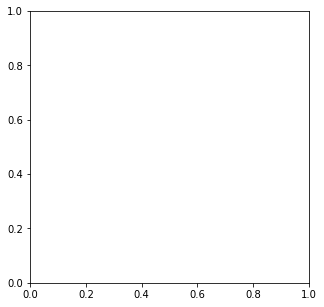

In [18]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(5, 5), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [ ]:
df.filter(["Appels"])

,Appels
Date,
2019-01-01,0
2019-01-02,6240
2019-01-03,6132
2019-01-04,6430
2019-01-05,4036
...,...
2021-09-26,711
2021-09-27,5860
2021-09-28,5160


In [27]:
# Settings and Model Labels
rolling_forecast_range = 30
epochs = 200
batch_size = 16
titletext = "Forecast Chart Model A"
ms = [
    ["epochs", epochs],
    ["batch_size", batch_size],
    ["lstm_neuron_number", neurons],
    ["rolling_forecast_range", rolling_forecast_range],
    ["layers", "LSTM, DENSE(1)"],
]
settings_text = ""
lms = len(ms)
for i in range(0, lms):
    settings_text += ms[i][0] + ": " + str(ms[i][1])
    
    if i < lms - 1:
        settings_text = settings_text + ",  "

# Making a Multi-Step Prediction
new_df = df.filter(["close"])
for i in range(0, rolling_forecast_range):
    last_values = new_df[-neurons:].values
    last_values_scaled = mmscaler.transform(last_values)
    X_input = []
    X_input.append(last_values_scaled)
    X_input = np.array(X_input)
    X_test = np.reshape(X_input, (X_input.shape[0], X_input.shape[1], 1))
    pred_value = model.predict(X_input)
    pred_value_unscaled = mmscaler.inverse_transform(pred_value)
    pred_value_f = round(pred_value_unscaled[0, 0], 4)
    next_index = new_df.iloc[[-1]].index.values + 1
    new_df = new_df.append(pd.DataFrame({"valid": pred_value_f}, index=next_index))
    new_df_length = new_df.size
    
forecast = new_df[new_df_length - rolling_forecast_range : new_df_length].rename(
    columns={"valid": "Forecast"}
    
)

/tmp/ipykernel_14655/2006085192.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(pd.DataFrame({"valid": pred_value_f}, index=next_index))


ValueError: X has 2 features, but MinMaxScaler is expecting 1 features as input.